Import Required Libraries

In [ ]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import re
from wordcloud import WordCloud
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Dense, Embedding, LSTM, Conv1D, MaxPool1D
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score

Data Collection and Preprocessing

Fake News Data

In [ ]:
fake = pd.read_csv("/content/drive/MyDrive/project/dataset/Fake.csv")
fake.head()

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"


In [ ]:
for key,count in fake.subject.value_counts().iteritems():
    print(f"{key}:\t{count}")
    
#Getting Total Rows
print(f"Total Records:\t{fake.shape[0]}")

News:	9050
politics:	6841
left-news:	4459
Government News:	1570
US_News:	783
Middle-east:	778
Total Records:	23481


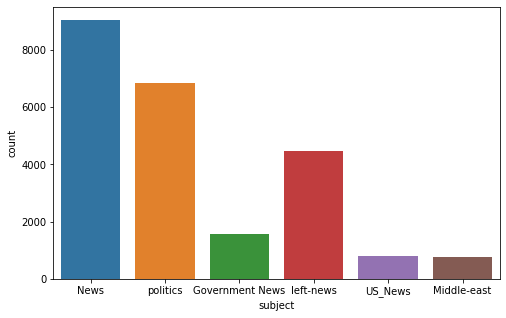

In [ ]:
plt.figure(figsize=(8,5))
sns.countplot("subject", data=fake)
plt.show()

In [ ]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

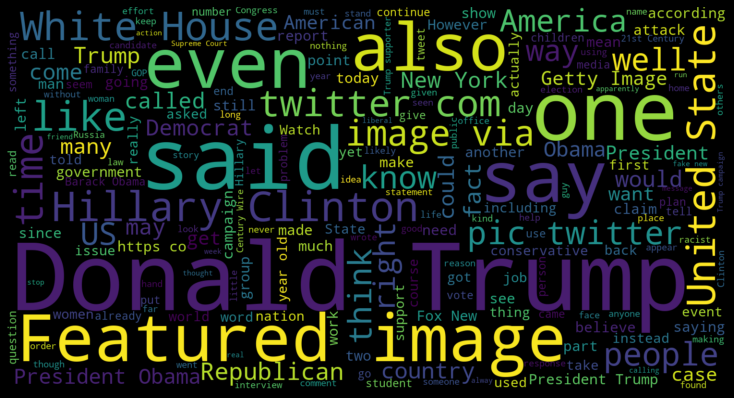

In [ ]:
text = ''
for news in fake.text.values:
    text += f" {news}"
wordcloud = WordCloud(
    width = 1500,
    height = 800,
    background_color = 'black',
    stopwords = set(nltk.corpus.stopwords.words("english"))).generate(text)
fig = plt.figure(
    figsize = (10, 7),
    facecolor = 'k',
    edgecolor = 'k')
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()
del text

In [ ]:
real = pd.read_csv("/content/drive/MyDrive/project/dataset/True.csv")
real.head()

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"


In [ ]:
for key,count in real.subject.value_counts().iteritems():
    print(f"{key}:\t{count}")
    
#Getting Total Rows
print(f"Total Records:\t{fake.shape[0]}")

politicsNews:	11272
worldnews:	10145


NameError: ignored

Get the Unknown publisher data

In [ ]:
unknown_publishers = []
for index,row in enumerate(real.text.values):
    try:
        record = row.split(" -", maxsplit=1)
        record[1]
        assert(len(record[0]) < 260)
    except:
        unknown_publishers.append(index)
real.iloc[unknown_publishers].text

3488     The White House on Wednesday disclosed a group...
4358     Neil Gorsuch, President Donald Trump’s appoint...
4465     WASHINGTON The clock began running out this we...
5784     Federal appeals court judge Neil Gorsuch, the ...
6660     Republican members of Congress are complaining...
6823     Over the course of the U.S. presidential campa...
7922     After going through a week reminiscent of Napo...
8194     The following timeline charts the origin and s...
8195     Global health officials are racing to better u...
8247     U.S. President Barack Obama visited a street m...
8465     ALGONAC, MICH.—Parker Fox drifted out of the D...
8481     Global health officials are racing to better u...
8482     The following timeline charts the origin and s...
8505     Global health officials are racing to better u...
8506     The following timeline charts the origin and s...
8771     In a speech weighted with America’s complicate...
8970                                                    

In [ ]:
real.iloc[8970]

NameError: ignored

In [ ]:
publisher = []
tmp_text = []
for index,row in enumerate(real.text.values):
    if index in unknown_publishers:
        #Add unknown of publisher not mentioned
        tmp_text.append(row)
        
        publisher.append("Unknown")
        continue
    record = row.split(" -", maxsplit=1)
    publisher.append(record[0])
    tmp_text.append(record[1])

real["publisher"] = publisher
real["text"] = tmp_text

del publisher, tmp_text, record, unknown_publishers

real.head()

,title,text,subject,date,publisher
0,"As U.S. budget fight looms, Republicans flip t...",The head of a conservative Republican faction...,politicsNews,"December 31, 2017",WASHINGTON (Reuters)
1,U.S. military to accept transgender recruits o...,Transgender people will be allowed for the fi...,politicsNews,"December 29, 2017",WASHINGTON (Reuters)
2,Senior U.S. Republican senator: 'Let Mr. Muell...,The special counsel investigation of links be...,politicsNews,"December 31, 2017",WASHINGTON (Reuters)
3,FBI Russia probe helped by Australian diplomat...,Trump campaign adviser George Papadopoulos to...,politicsNews,"December 30, 2017",WASHINGTON (Reuters)
4,Trump wants Postal Service to charge 'much mor...,President Donald Trump called on the U.S. Pos...,politicsNews,"December 29, 2017",SEATTLE/WASHINGTON (Reuters)


In [ ]:
[index for index,text in enumerate(real.text.values) if str(text).strip() == '']

[8970]

In [ ]:
real = real.drop(8970, axis=0)
empty_fake_index = [index for index,text in enumerate(fake.text.values) if str(text).strip() == '']
print(f"No of empty rows: {len(empty_fake_index)}")
fake.iloc[empty_fake_index].tail()

No of empty rows: 630


,title,text,subject,date
21816,BALTIMORE BURNS: MARYLAND GOVERNOR BRINGS IN N...,,left-news,"Apr 27, 2015"
21826,FULL VIDEO: THE BLOCKBUSTER INVESTIGATION INTO...,,left-news,"Apr 25, 2015"
21827,(VIDEO) HILLARY CLINTON: RELIGIOUS BELIEFS MUS...,,left-news,"Apr 25, 2015"
21857,(VIDEO)ICE PROTECTING OBAMA: WON’T RELEASE NAM...,,left-news,"Apr 14, 2015"
21873,(VIDEO) HYSTERICAL SNL TAKE ON HILLARY’S ANNOU...,,left-news,"Apr 12, 2015"


Total Records:	21416
politicsNews:	11271
worldnews:	10145


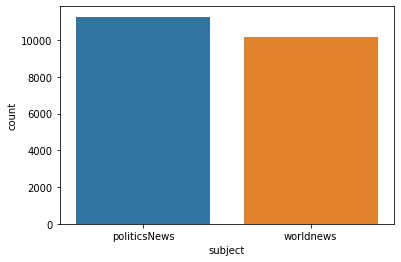

In [ ]:
#Getting Total Rows
print(f"Total Records:\t{real.shape[0]}")

#Counting by Subjects 
for key,count in real.subject.value_counts().iteritems():
  print(f"{key}:\t{count}")

sns.countplot(x="subject", data=real)
plt.show()

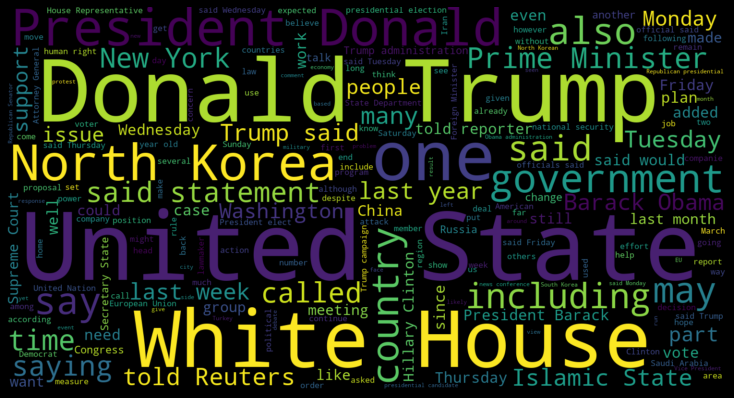

In [ ]:
text = ''
for news in real.text.values:
    text += f" {news}"
wordcloud = WordCloud(
    width = 1500,
    height = 800,
    background_color = 'black',
    stopwords = set(nltk.corpus.stopwords.words("english"))).generate(str(text))
fig = plt.figure(
    figsize = (10, 7),
    facecolor = 'k',
    edgecolor = 'k')
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()
del text

Give classes for real and fake news

In [ ]:
real["class"] = 1
fake["class"] = 0

real["text"] = real["title"] + " " + real["text"]
fake["text"] = fake["title"] + " " + fake["text"]

real = real.drop(["subject", "date","title",  "publisher"], axis=1)
fake = fake.drop(["subject", "date", "title"], axis=1)

data = real.append(fake, ignore_index=True)
del real, fake

In [ ]:
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

Remove Stopwords

In [ ]:
y = data["class"].values
X = []
stop_words = set(nltk.corpus.stopwords.words("english"))
tokenizer = nltk.tokenize.RegexpTokenizer(r'\w+')
for par in data["text"].values:
    tmp = []
    sentences = nltk.sent_tokenize(par)
    for sent in sentences:
        sent = sent.lower()
        tokens = tokenizer.tokenize(sent)
        filtered_words = [w.strip() for w in tokens if w not in stop_words and len(w) > 1]
        tmp.extend(filtered_words)
    X.append(tmp)

del data

Training Module

In [ ]:
import gensim

Declare the Pre-trained Model

In [ ]:
EMBEDDING_DIM = 100

w2v_model = gensim.models.Word2Vec(sentences=X, size=EMBEDDING_DIM, window=5, min_count=1)

In [ ]:
len(w2v_model.wv.vocab)

122248

In [ ]:
w2v_model["corona"]

array([ 0.01865852,  0.04116006, -0.01239513,  0.0119525 , -0.05467556,
       -0.02108657, -0.04031311,  0.05161362, -0.01722196,  0.00077618,
       -0.03980576, -0.0305783 ,  0.02588359, -0.01003946, -0.13172875,
        0.00729539,  0.00993092, -0.03240802,  0.00315654, -0.03536217,
        0.00661596,  0.06875767, -0.03016098,  0.02204719,  0.00855467,
        0.03009456, -0.06344386, -0.03842915,  0.0079492 , -0.10226285,
       -0.04352586, -0.00349113, -0.07435671,  0.01621491,  0.09284056,
        0.04794441,  0.07973497, -0.04834338,  0.02207111,  0.01894785,
       -0.05768787,  0.02267538, -0.04150105,  0.01912269, -0.01683864,
        0.06315031, -0.00317799,  0.00495977, -0.08671371, -0.03708356,
       -0.04194436,  0.00332824,  0.04302382,  0.02611347, -0.03275365,
        0.08225977, -0.02556341,  0.05169791, -0.01031109, -0.03989012,
       -0.00085031, -0.01958286,  0.07467139, -0.04369021,  0.03158283,
        0.0659582 , -0.00961335, -0.00635864,  0.00206484, -0.03

In [ ]:
w2v_model.wv.most_similar("facebook")

[('fb', 0.669685959815979),
 ('reddit', 0.6619334816932678),
 ('instagram', 0.6525401473045349),
 ('google', 0.6438126564025879),
 ('posting', 0.624420702457428),
 ('gofundme', 0.6159000992774963),
 ('online', 0.5896947383880615),
 ('potone', 0.5727028250694275),
 ('whatsapp', 0.570495069026947),
 ('hashtag', 0.5501553416252136)]

In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X)

X = tokenizer.texts_to_sequences(X)
X[0][:10]

[389, 395, 10495, 54, 5509, 1286, 4840, 315, 205, 16]

In [ ]:
word_index = tokenizer.word_index
for word, num in word_index.items():
    print(f"{word} -> {num}")
    if num == 10:
        break  

trump -> 1
said -> 2
president -> 3
would -> 4
people -> 5
one -> 6
state -> 7
new -> 8
obama -> 9
also -> 10


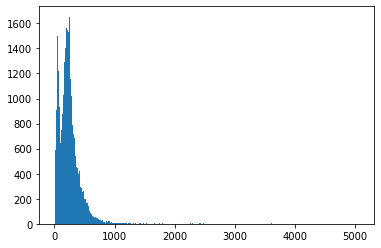

In [ ]:
plt.hist([len(x) for x in X], bins=500)
plt.show()

In [ ]:
nos = np.array([len(x) for x in X])
len(nos[nos  < 700])

43982

In [ ]:
maxlen = 700 

X = pad_sequences(X, maxlen=maxlen)

Getting Weigth matrix

In [ ]:
vocab_size = len(tokenizer.word_index) + 1
def get_weight_matrix(model, vocab):
    vocab_size = len(vocab) + 1
    weight_matrix = np.zeros((vocab_size, EMBEDDING_DIM))
    for word, i in vocab.items():
        weight_matrix[i] = model[word]
    return weight_matrix
embedding_vectors = get_weight_matrix(w2v_model, word_index)

In [ ]:
model = Sequential()
model.add(Embedding(vocab_size, output_dim=EMBEDDING_DIM, weights=[embedding_vectors], input_length=maxlen, trainable=False))
model.add(LSTM(units=128))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

del embedding_vectors

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 700, 100)          12224900  
                                                                 
 lstm (LSTM)                 (None, 128)               117248    
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 12,342,277
Trainable params: 117,377
Non-trainable params: 12,224,900
_________________________________________________________________


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [ ]:
model.fit(X_train, y_train, validation_split=0.3, epochs=6)

Epoch 1/6
737/737 [==============================] - 554s 751ms/step - loss: 0.0390 - acc: 0.9871 - val_loss: 0.0243 - val_acc: 0.9920
Epoch 2/6
737/737 [==============================] - 544s 738ms/step - loss: 0.0193 - acc: 0.9938 - val_loss: 0.0175 - val_acc: 0.9944
Epoch 3/6
737/737 [==============================] - 551s 747ms/step - loss: 0.0163 - acc: 0.9946 - val_loss: 0.0470 - val_acc: 0.9815
Epoch 4/6
737/737 [==============================] - 548s 744ms/step - loss: 0.0207 - acc: 0.9936 - val_loss: 0.0210 - val_acc: 0.9934
Epoch 5/6
737/737 [==============================] - 541s 734ms/step - loss: 0.0095 - acc: 0.9971 - val_loss: 0.0221 - val_acc: 0.9930
Epoch 6/6
737/737 [==============================] - 538s 730ms/step - loss: 0.0076 - acc: 0.9977 - val_loss: 0.0162 - val_acc: 0.9950


In [ ]:
y_pred = (model.predict(X_test) >= 0.5).astype("int")

Confusion Matrix:



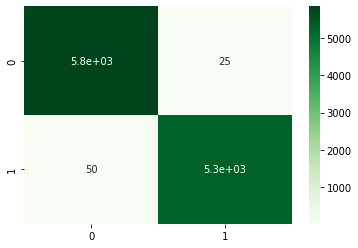

[[5843   25]
 [  50 5307]]


In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import matplotlib.pyplot as plt
cm = confusion_matrix(y_test, y_pred, labels=[0,1])
sn.heatmap(cm, cmap = "Greens", annot = True)
print("Confusion Matrix:\n")
plt.show()
print(cm)

In [ ]:
acc = accuracy_score(y_test, y_pred)
print(acc)
print(classification_report(y_test, y_pred))

0.9933184855233853
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      5868
           1       1.00      0.99      0.99      5357

    accuracy                           0.99     11225
   macro avg       0.99      0.99      0.99     11225
weighted avg       0.99      0.99      0.99     11225



In [ ]:
x = ['the beadon put the drump into jail']
x = tokenizer.texts_to_sequences(x)
x = pad_sequences(x, maxlen=maxlen)

In [ ]:
(model.predict(x) >= 0.5).astype(int)

array([[0]])

In [ ]:
x = ["""CHENNAI: Tamil Nadu continued to add more than 100 cases on Thursday for the second consecutive day, when the state reported 145 new cases. This was despite a reduction in new cases (33 ) reported from Vellore Institute of Technology in Chengalpet. No deaths were reported, but active cases in the state rose to 711.
Public health officials said clusters are now being reported by diagnostic labs from workplaces, apartment complexes and within families too.
Chennai reported 58 new cases while Chengalpet logged 53 cases. While Tiruvallur reported a dozen new cases, ther e were eight in Coimbatore, four in Krishnagiri, and two each in Kancheepuram, Ranipet and Vellore. Dharmapuri, Kanyakumari and Tirupur reported one new case each.
One patient, who arrived from the UAE, tested p ositive. “In almost every wave we have seen, cases increase in Chennai a few days after Mumbai. We are now seeing an increa se in the positivity rate in Mumbai,” said health secretary J Radhakrishnan.
While the state has managed to increase testing to nearly 15,000 a day, public health officials said many people with symptoms do not opt for testing. “Worse, they don’t isolate themselves. This leads to increased transmission rates,” said public health director Dr TS Selvavinayagam. Early information from doctors show that many people have symptoms including sore throat, cold and fatigue for more than two days.
While genomic tests have so far not indicated the presence of BA 4 and BA 5 clusters, experts have not ruled out possibilities as several other states have identified clusters of BA4 and BA5. Studies, that are yet to be peer-reviewed, are now indicating that rein fections within a week to 10 days are possible among people who are not vaccinated.
More than 80% of the active cases in the state were reported from Chennai (326) and Chengalpet (261). While Coimbatore had 29 active cases, Tiruvallur had 26 and Kancheepuram reported 13 new cases."""]
x = tokenizer.texts_to_sequences(x)
x = pad_sequences(x, maxlen=maxlen)

In [ ]:
(model.predict(x) >= 0.5).astype(int)

array([[1]])

In [ ]:
model.save_weights('model_weights.h5')

    # Save the model architecture
with open('model_architecture.json', 'w') as f:
        f.write(model.to_json())

    # Save the tokenizer
with open('tokenizer.json', 'w') as f:
        f.write(tokenizer.to_json())